In [37]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
import PIL
import splitfolders

In [38]:
# WE USED SPLIT-FOLDER LIBRARY TO SPILT THE DATASET INTO TRAINIG SET, VALIDATION SET AND TEST SET. WE USED 

# splitfolders.ratio('PlantVillage', output="output", seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

In [39]:
image_size = (256, 256)

In [40]:
train = keras.preprocessing.image_dataset_from_directory(
   'output/train',
    labels='inferred',
    label_mode='int',
    shuffle=True,
    image_size = (256,256),
)

val = keras.preprocessing.image_dataset_from_directory(
   'output/val',
    labels='inferred',
    label_mode='int',
    shuffle=True,
    image_size = (256,256),
)

test = keras.preprocessing.image_dataset_from_directory(
   'output/test',
    label_mode='int',
    shuffle=True,
    image_size = (256,256),
)


Found 14437 files belonging to 15 classes.
Found 4121 files belonging to 15 classes.
Found 2075 files belonging to 15 classes.


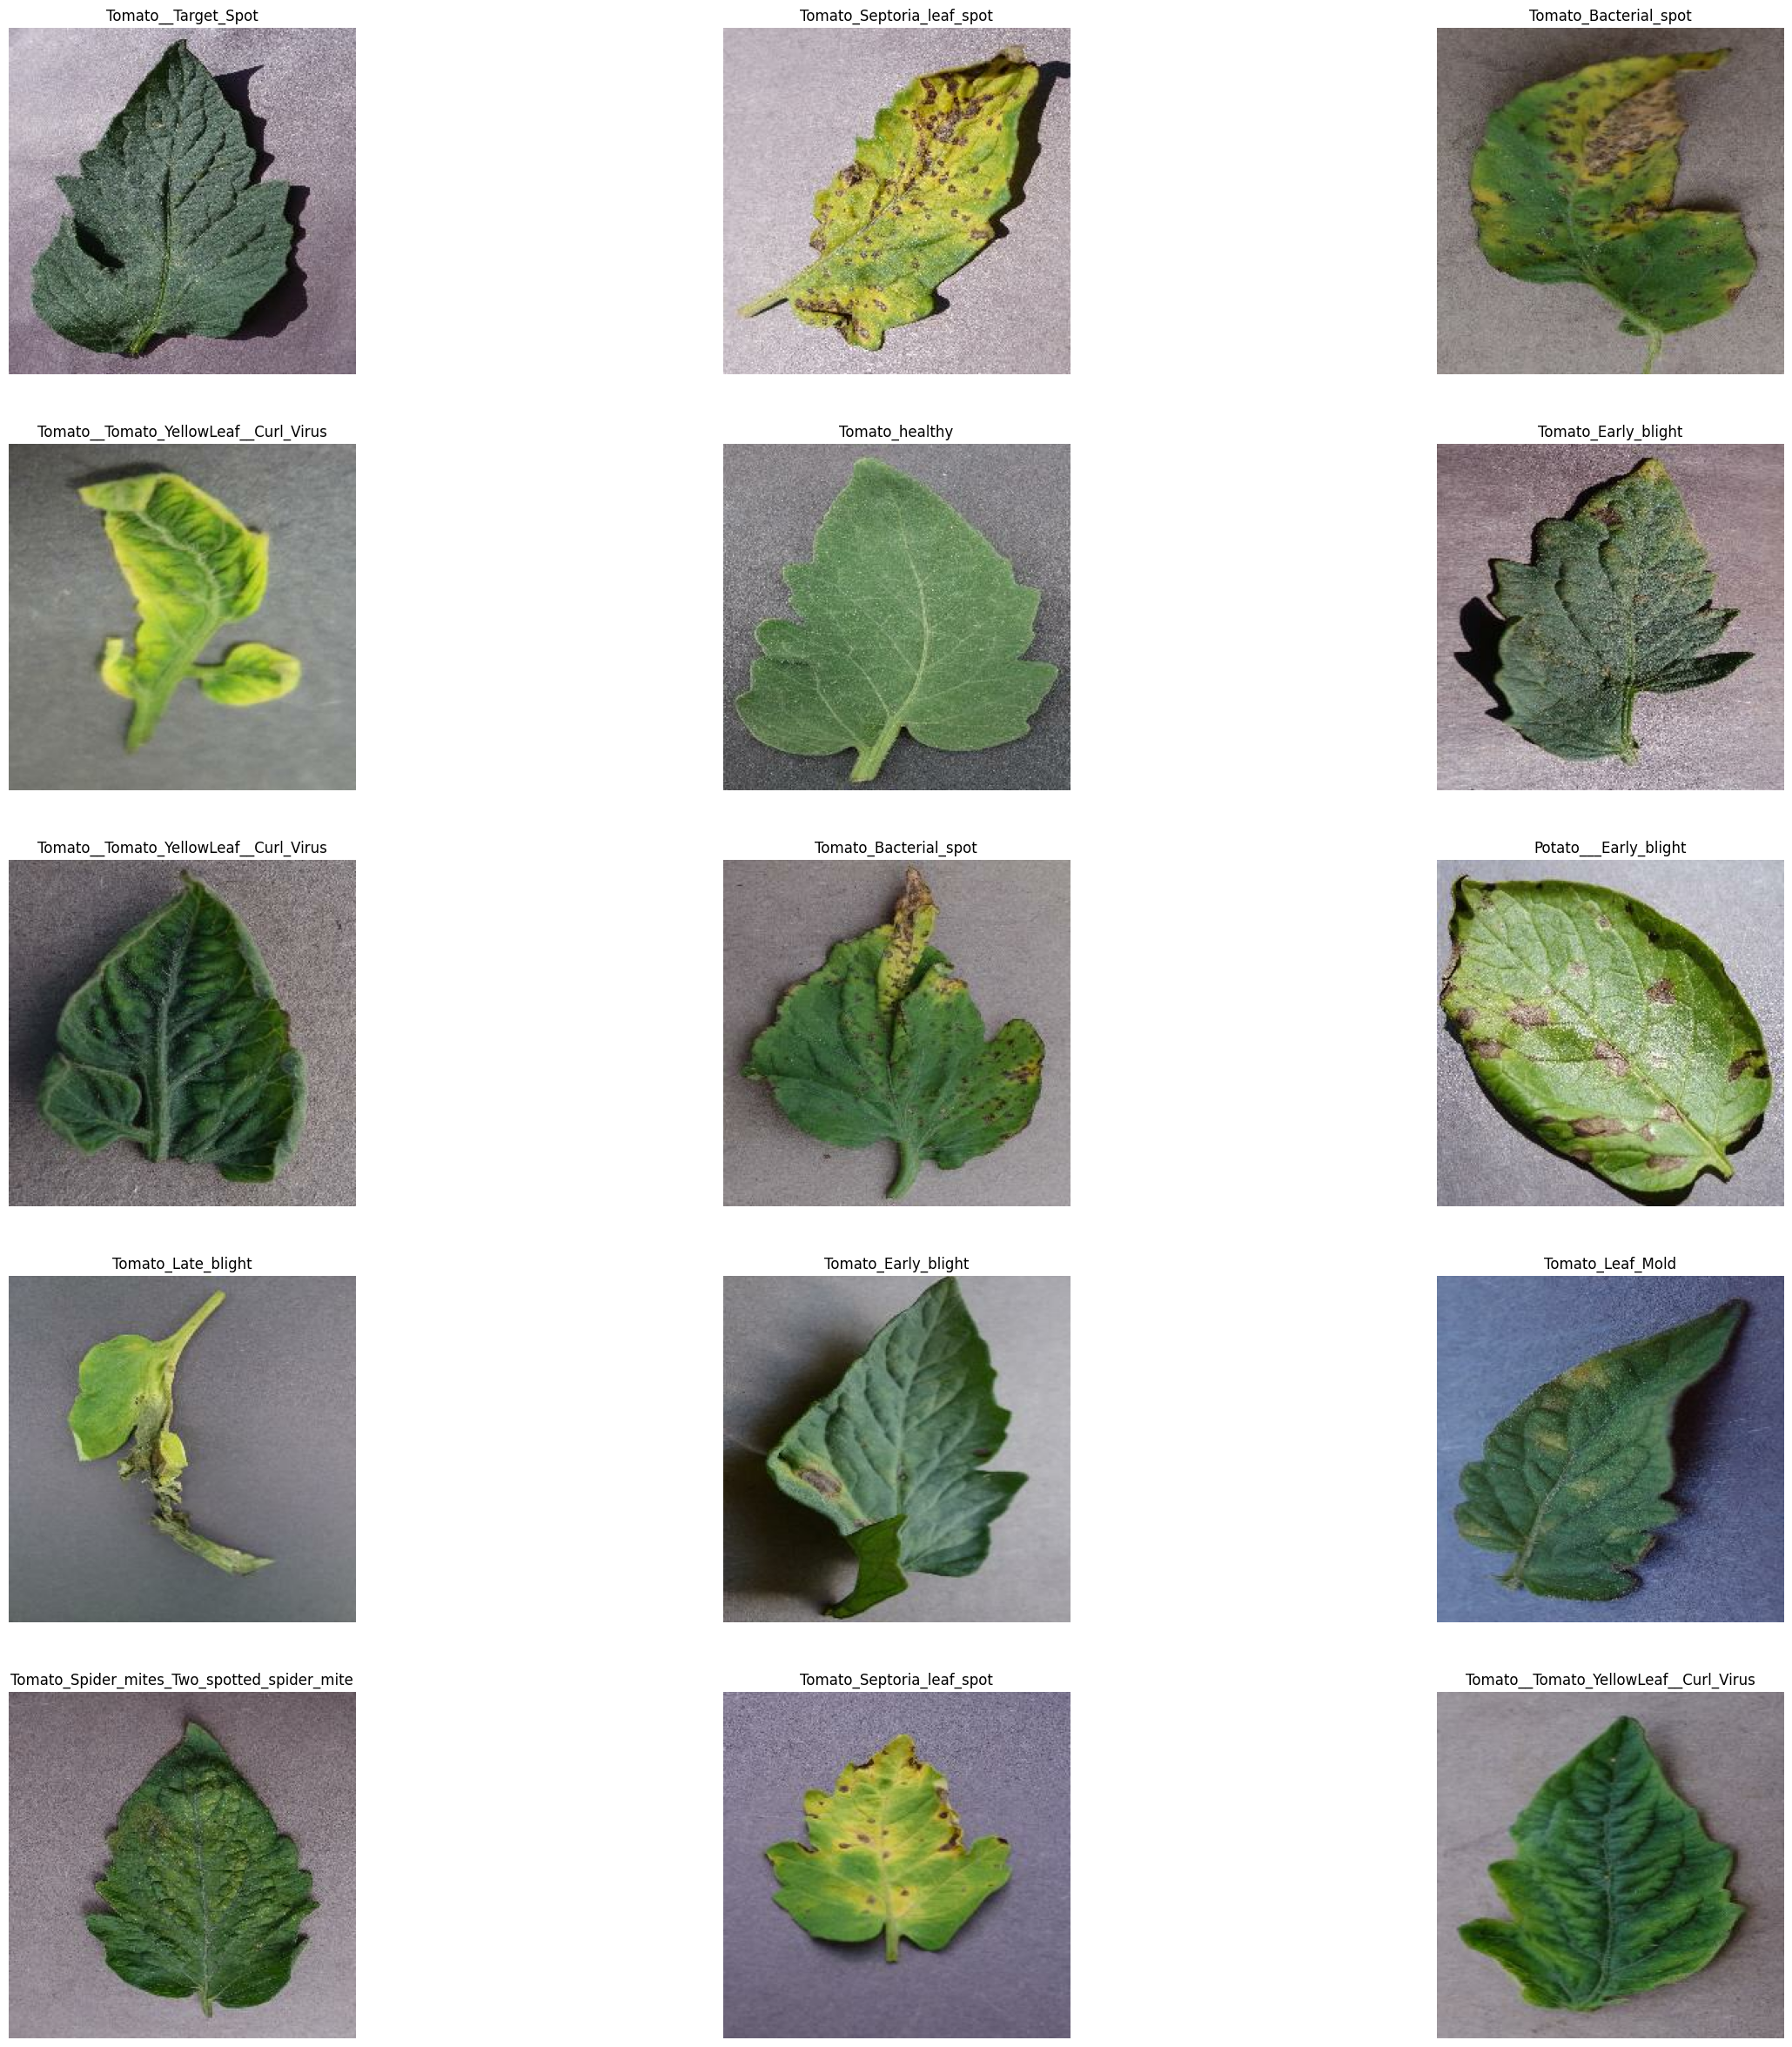

In [41]:
class_names = train.class_names

plt.figure(figsize=(30, 30))
for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



In [42]:
data_augmentation_layers = [
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

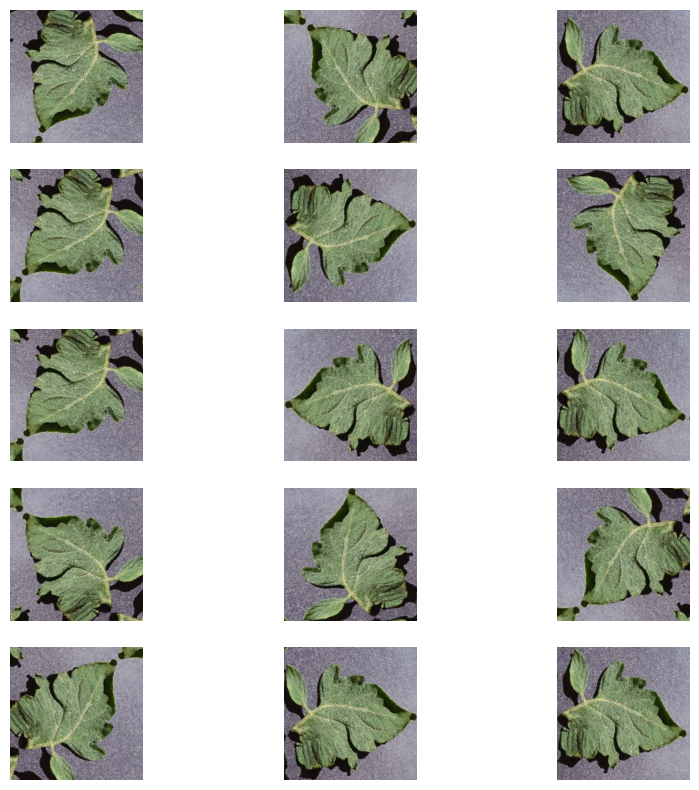

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")



<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[1.09727455e+02, 1.03727455e+02, 1.15727463e+02],
         [1.22704483e+02, 1.16704491e+02, 1.28704498e+02],
         [1.10958771e+02, 1.04958763e+02, 1.16958763e+02],
         ...,
         [1.30613068e+02, 1.31613068e+02, 1.49613068e+02],
         [1.31186829e+02, 1.32186829e+02, 1.50186829e+02],
         [1.65167923e+02, 1.66167923e+02, 1.84167923e+02]],

        [[1.13223839e+02, 1.07223846e+02, 1.19223846e+02],
         [1.06847961e+02, 1.00847961e+02, 1.12847961e+02],
         [1.22260223e+02, 1.16260223e+02, 1.28260223e+02],
         ...,
         [1.42406189e+02, 1.43406189e+02, 1.61406189e+02],
         [1.54864426e+02, 1.55864426e+02, 1.73864441e+02],
         [1.53419739e+02, 1.54419739e+02, 1.72419754e+02]],

        [[1.29893967e+02, 1.23893967e+02, 1.35893951e+02],
         [1.26927483e+02, 1.20927483e+02, 1.32927490e+02],
         [1.38522614e+02, 1.32522614e+02, 1.44522614e+02],
         ...,
         [

In [31]:
# def process(image,label):
#     image = tf.cast(image/255. ,tf.float32)
#     return image,label

# train = train.map(process)
# val = val.map(process)

In [32]:
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)

In [33]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val
)

Epoch 1/25


In [ ]:
# img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

# predictions = model.predict(img_array)
# score = float(keras.ops.sigmoid(predictions[0][0]))
# print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [ ]:
# train_data = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# valid_data = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_data = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# resize_scale = tf.keras.Sequential([
#     layers.Resizing(256,256),
#     layers.Rescaling(1.0/255)
# ])

In [ ]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2)
# ])

In [ ]:
# input_shape = (32, 256,256, 3)

# model = tf.keras.Sequential([
#     resize_scale,
#     data_augmentation,
#     layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64,activation='relu'),
#     layers.Dense(len(class_names),activation='softmax'),
# ])
# model.build(input_shape=input_shape)
# model.summary()

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

In [ ]:
# model.fit(
#     train,
#     epochs=5,
#     batch_size=32,
#     verbose=1,
#     validation_data=val
# )

In [ ]:
# model.evaluate(test_data)

In [ ]:
# for image_batch,label_batch in test_data.take(1):
#     plt.imshow(image_batch[0].numpy().astype("uint8"))
#     print("The Image Title : ",class_names[label_batch[0].numpy()])
#     prediction = model.predict(image_batch)
#     print("Model Predicted label : ",class_names[np.argmax(prediction[0])])